In [353]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [354]:
df = pd.read_csv('ola_driver_scaler.csv')

In [355]:
# We have monthly information for a segment of drivers in the years 2019 and 2020.
# We only need one row per driver for model building, hence aggregation needs to be done. 
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


#### Column Profiling:

- <b>MMMM-YY</b> : Reporting Date (Monthly)
- <b>Driver_ID</b> : Unique id for drivers
- <b>Age</b> : Age of the driver
- <b>Gender</b> : Gender of the driver – Male : 0, Female: 1
- <b>City</b> : City Code of the driver
- <b>Education_Level</b> : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- <b>Income</b> : Monthly average Income of the driver
- <b>Date Of Joining</b> : Joining date for the driver
- <b>LastWorkingDate</b> : Last date of working for the driver
- <b>Joining Designation</b> : Designation of the driver at the time of joining
- <b>Grade</b> : Grade of the driver at the time of reporting
- <b>Total Business Value</b> : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- <b>Quarterly Rating</b> : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [356]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [357]:
df.shape

(19104, 13)

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [359]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,19104.0,1415.591133,8.107053e+02,1.0,710.0,1417.0,2137.0,2788.0
Age,19043.0,34.668435,6.257912e+00,21.0,30.0,34.0,39.0,58.0
Gender,19052.0,0.418749,4.933670e-01,0.0,0.0,0.0,1.0,1.0
Education_Level,19104.0,1.021671,8.001671e-01,0.0,0.0,1.0,2.0,2.0
Income,19104.0,65652.025126,3.091452e+04,10747.0,42383.0,60087.0,83969.0,188418.0
Joining Designation,19104.0,1.690536,8.369837e-01,1.0,1.0,1.0,2.0,5.0
Grade,19104.0,2.252670,1.026512e+00,1.0,1.0,2.0,3.0,5.0
Total Business Value,19104.0,571662.074958,1.128312e+06,-6000000.0,0.0,250000.0,699700.0,33747720.0
Quarterly Rating,19104.0,2.008899,1.009832e+00,1.0,1.0,2.0,3.0,4.0


In [360]:
df.describe(exclude=np.number).T

,count,unique,top,freq
MMM-YY,19104,24,01/01/19,1022
City,19104,29,C20,1008
Dateofjoining,19104,869,23/07/15,192
LastWorkingDate,1616,493,29/07/20,70


In [361]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [362]:
#Converting date of joining and last working date to datetime columns
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [363]:
# Before aggregation, we need to sort or order the data wrt reporting date and driver ID as we need the last values for every
# drive for grouping by
df.sort_values(by=['Driver_ID', 'MMM-YY'], inplace = True)

In [364]:
# There is no need of reporting date for EDA and model building
df.drop(['MMM-YY'], axis = 1, inplace = True)

In [365]:
df1 = df.groupby(by='Driver_ID').agg({'Age':'last', 'Gender':'last', 'City':'last', 'Education_Level':'last', 'Income':'last',
                                'Dateofjoining':'min', 'LastWorkingDate':'last', 'Joining Designation':'min', 'Grade':'last',
                                'Total Business Value':'sum', 'Quarterly Rating':'last'})
df1.reset_index(inplace=True)

In [366]:
df1.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2
1,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
2,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,350000,1
3,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,120360,1
4,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,1265000,2


In [367]:
# Dropping driver_id
df1.drop('Driver_ID', axis=1, inplace=True)

#### Feature Engineering

In [368]:
# For all rows having last working date as null means the driver has not left the company. Creating a new column which is
# our target variable on the bais of lastworking date. 1 - Driver left, 0 - Still working
def target(row):
    if pd.isna(row):
        return 0
    return 1
df1['target'] = df1['LastWorkingDate'].apply(target)

In [369]:
df1['target'].value_counts()

1    1616
0     765
Name: target, dtype: int64

In [370]:
# Creating a new column which tells whether the monthly income has increased for a particular driver
joining_inc = df.groupby('Driver_ID').agg({'Income':'first'}).values.reshape(-1,)
latest_inc = df.groupby('Driver_ID').agg({'Income':'last'}).values.reshape(-1,)
income_increase = latest_inc - joining_inc
df1['income increase'] = income_increase
df1['income increase'] = df1['income increase'].apply(lambda row: 1 if row > 0 else 0)

In [371]:
df1['income increase'].value_counts()

0    2340
1      41
Name: income increase, dtype: int64

In [372]:
# Creating a new column which tells whether the quaterly rating has increased for a particular driver
joining_quart_rating = df.groupby('Driver_ID').agg({'Quarterly Rating':'first'}).values.reshape(-1,)
latest_quart_rating = df.groupby('Driver_ID').agg({'Quarterly Rating':'last'}).values.reshape(-1,)
quart_rating_increase = latest_quart_rating - joining_quart_rating
df1['quarterly rating increase'] = quart_rating_increase
df1['quarterly rating increase'] = df1['quarterly rating increase'].apply(lambda row: 1 if row > 0 else 0)

In [373]:
df1['quarterly rating increase'].value_counts()

0    2016
1     365
Name: quarterly rating increase, dtype: int64

In [374]:
# Getting feature engineering month, day and year for date_time columns dateofjoining and last working date
df1['DOJ_month'] = df1['Dateofjoining'].dt.month
df1['DOJ_year'] = df1['Dateofjoining'].dt.year
df1['DOJ_day'] = df1['Dateofjoining'].dt.day
df1['LWD_month'] = df1['LastWorkingDate'].dt.month
df1['LWD_year'] = df1['LastWorkingDate'].dt.year
df1['LWD_day'] = df1['LastWorkingDate'].dt.day
df1.drop(['Dateofjoining', 'LastWorkingDate'], axis = 1, inplace = True)

In [375]:
df1.head(3)

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,income increase,quarterly rating increase,DOJ_month,DOJ_year,DOJ_day,LWD_month,LWD_year,LWD_day
0,28.0,0.0,C23,2,57387,1,1,1715580,2,1,0,0,12,2018,24,3.0,2019.0,11.0
1,31.0,0.0,C7,2,67016,2,2,0,1,0,0,0,11,2020,6,NaN,NaN,NaN
2,43.0,0.0,C13,2,65603,2,2,350000,1,1,0,0,12,2019,7,4.0,2020.0,27.0


#### Splitting the data_frame to get training and test sets

In [376]:
from sklearn.model_selection import train_test_split

In [377]:
# Initializing x(d independent features with n rows) and y(target variable)
train_df, test_df = train_test_split(df1, train_size=0.8, random_state=42)

In [378]:
train_df.shape, test_df.shape

((1904, 18), (477, 18))

#### EDA on train data set

In [379]:
train_df.head(3)

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,income increase,quarterly rating increase,DOJ_month,DOJ_year,DOJ_day,LWD_month,LWD_year,LWD_day
457,28.0,0.0,C10,0,87872,3,3,0,1,0,0,0,11,2020,23,NaN,NaN,NaN
1739,34.0,0.0,C20,0,38619,2,2,466160,1,1,0,0,11,2019,15,3.0,2020.0,23.0
1848,27.0,0.0,C9,0,53105,1,2,0,1,1,0,0,2,2017,10,2.0,2019.0,19.0


In [380]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1904.0,3.371954e+01,6.001674e+00,21.0,29.00,33.0,37.0,55.0
Gender,1904.0,4.096639e-01,4.919009e-01,0.0,0.00,0.0,1.0,1.0
Education_Level,1904.0,1.011029e+00,8.145963e-01,0.0,0.00,1.0,2.0,2.0
Income,1904.0,5.953179e+04,2.843289e+04,10747.0,39403.75,55469.0,76080.0,188418.0
Joining Designation,1904.0,1.829307e+00,8.446066e-01,1.0,1.00,2.0,2.0,5.0
Grade,1904.0,2.100840e+00,9.436679e-01,1.0,1.00,2.0,3.0,5.0
Total Business Value,1904.0,4.698606e+06,9.252240e+06,-1385530.0,0.00,859970.0,4316170.0,95331060.0
Quarterly Rating,1904.0,1.507878e+00,8.686403e-01,1.0,1.00,1.0,2.0,4.0
target,1904.0,6.769958e-01,4.677472e-01,0.0,0.00,1.0,1.0,1.0
income increase,1904.0,1.733193e-02,1.305392e-01,0.0,0.00,0.0,0.0,1.0


In [381]:
train_df.describe(exclude=np.number).T

,count,unique,top,freq
City,1904,29,C20,123


In [382]:
train_df.columns

Index(['Age', 'Gender', 'City', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating', 'target', 'income increase',
       'quarterly rating increase', 'DOJ_month', 'DOJ_year', 'DOJ_day',
       'LWD_month', 'LWD_year', 'LWD_day'],
      dtype='object')

In [383]:
# Seperating categorical and continuos features from the data set
cat_fea = ['Age', 'Gender', 'City', 'Education_Level', 'Joining Designation', 
           'Grade',  'Quarterly Rating', 'target', 'income increase','quarterly rating increase', 
           'DOJ_month', 'DOJ_year', 'DOJ_day','LWD_month', 'LWD_year', 'LWD_day']
cont_fea = ['Income', 'Total Business Value']

##### Univariate analysis

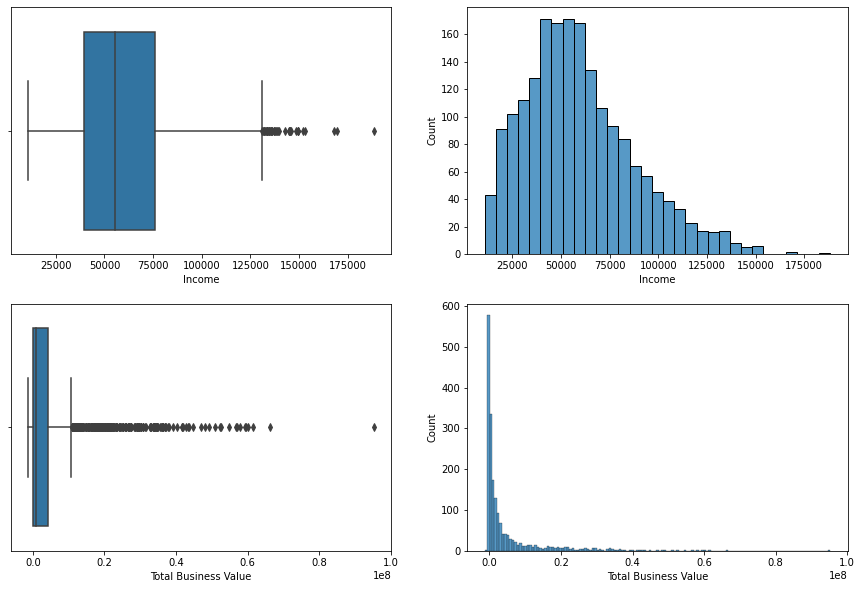

In [384]:
plt.figure(figsize=(15,10))
i = 1
for features in cont_fea:
    plt.subplot(2,2,i)
    sns.boxplot(train_df[features])
    plt.subplot(2,2,i+1)
    sns.histplot(train_df[features])
    i+=2

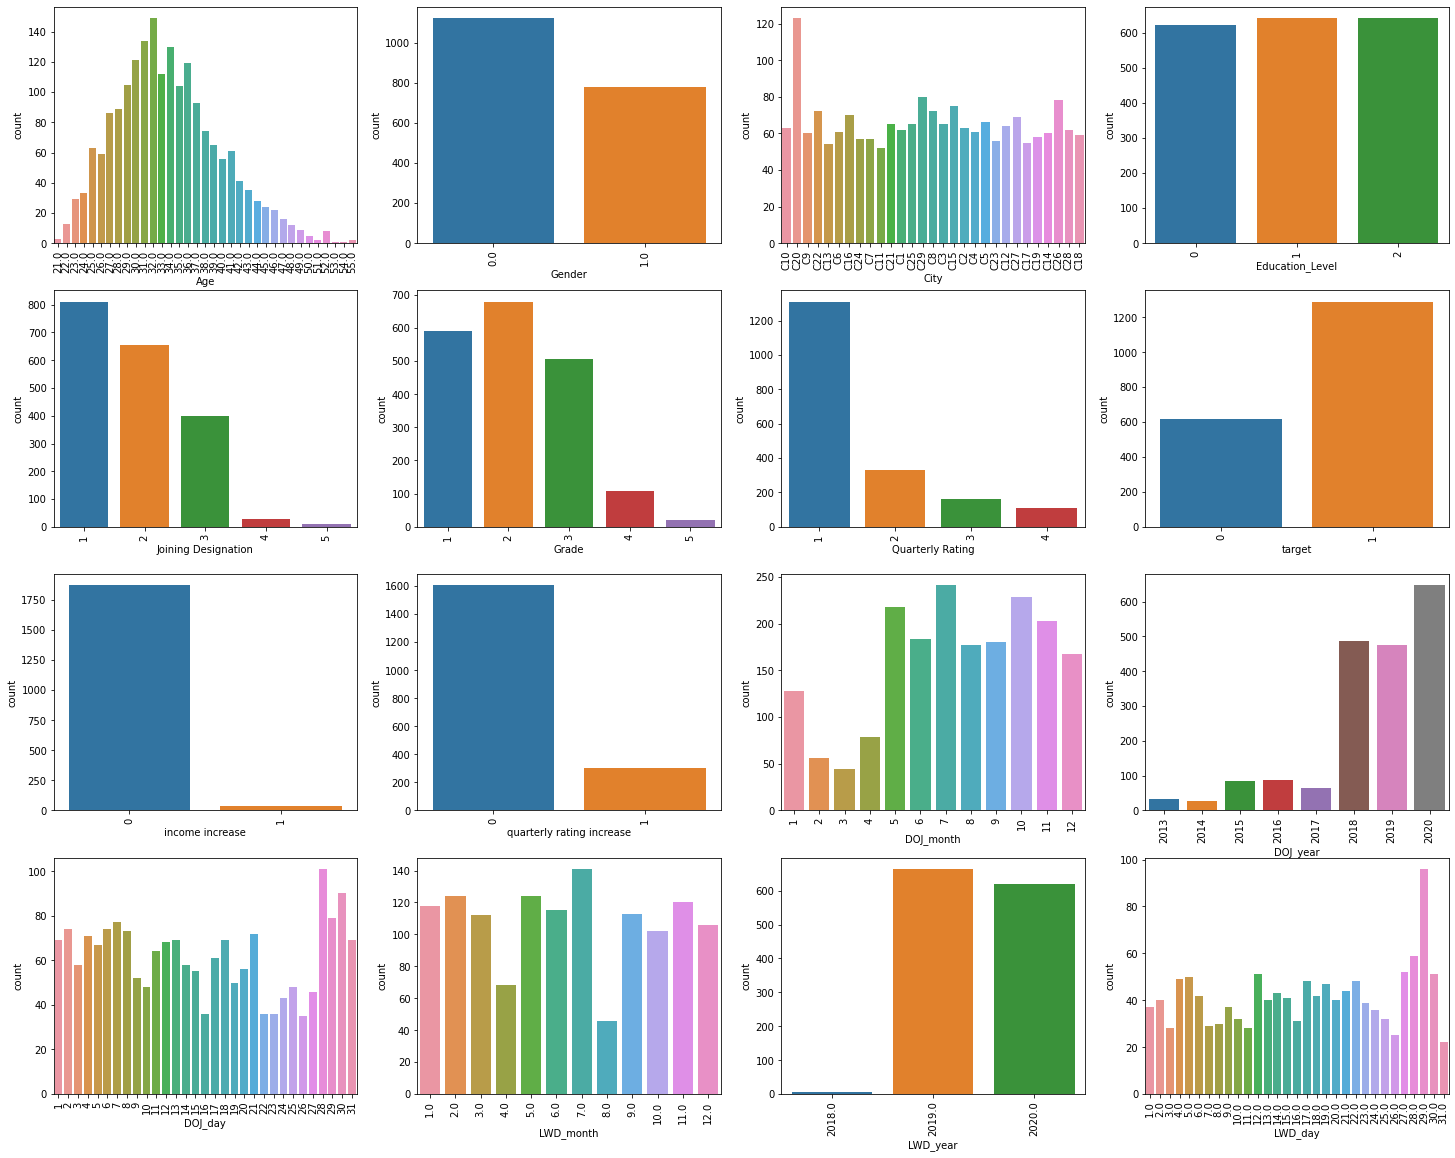

In [385]:
plt.figure(figsize=(25,20))
i = 1
for features in cat_fea:
    plt.subplot(4,4,i)
    sns.countplot(train_df[features])
    plt.xticks(rotation='90')
    i+=1
plt.show()

##### Multivariate analysis

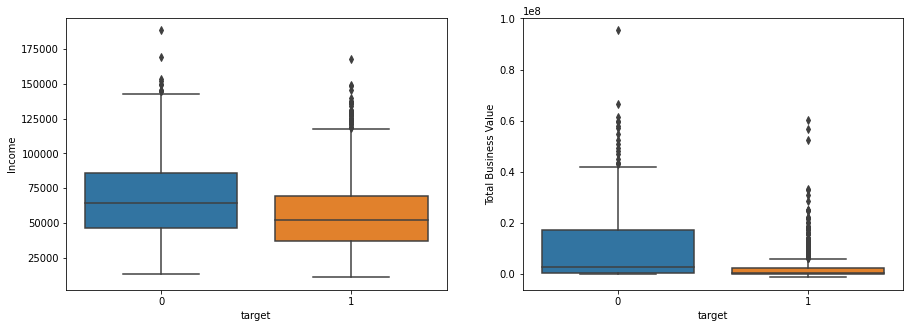

In [386]:
plt.figure(figsize=(15,5))
i = 1
for features in cont_fea:
    plt.subplot(1,2,i)
    sns.boxplot(y = train_df[features], x = train_df['target'])
    i+=1

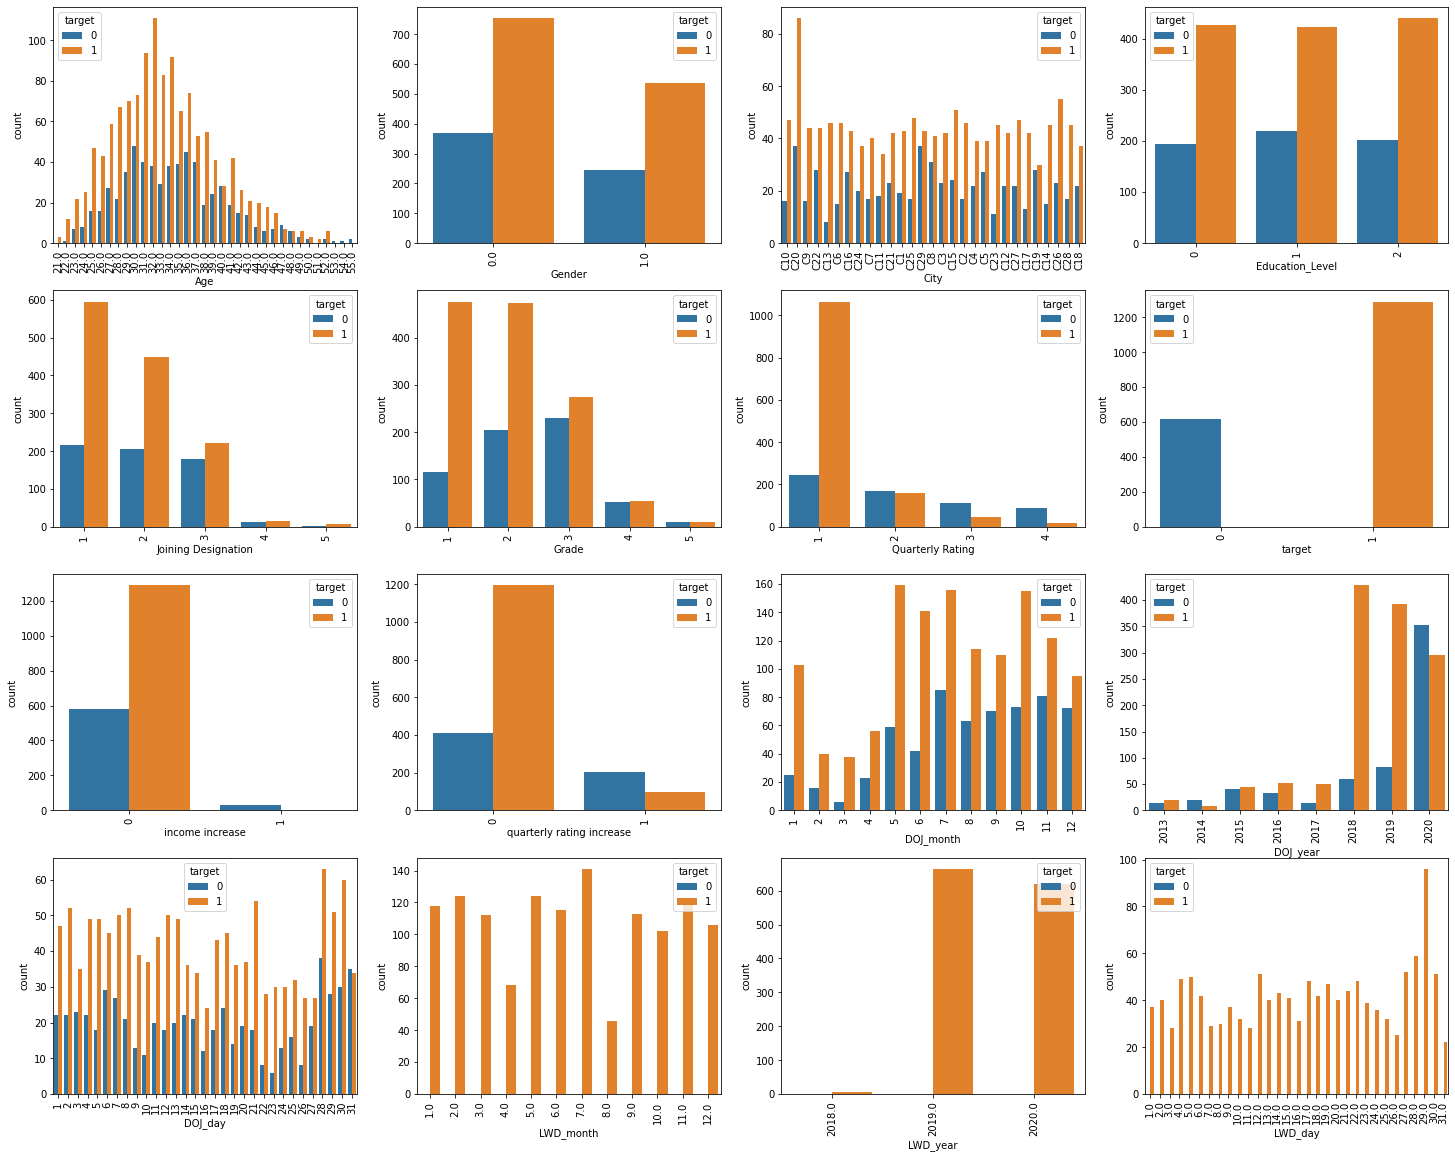

In [388]:
plt.figure(figsize=(25,20))
i = 1
for features in cat_fea:
    plt.subplot(4,4,i)
    sns.countplot(train_df[features], hue = train_df['target'])
    plt.xticks(rotation='90')
    i+=1
plt.show()

#### Feature Encoding

In [306]:
# We will go with target encoding instead of OHE as there are many categories in City feature
from category_encoders import TargetEncoder

In [307]:
# We have only once object that is city which needs to be encoded. Both train and test data sets need to be encoded individually
train_df['City'] = TargetEncoder().fit_transform(train_df['City'],train_df['target']).values.reshape(-1,)
test_df['City'] = TargetEncoder().fit_transform(test_df['City'],test_df['target']).values.reshape(-1,)

In [308]:
# As the EDA is almost done now and since we created the target variable on the basis of Last working date, dropping
# LWD_month, year and day
train_df.drop(['LWD_month', 'LWD_year', 'LWD_day'], axis = 1, inplace = True)
test_df.drop(['LWD_month', 'LWD_year', 'LWD_day'], axis = 1, inplace = True)

#### HeatMap

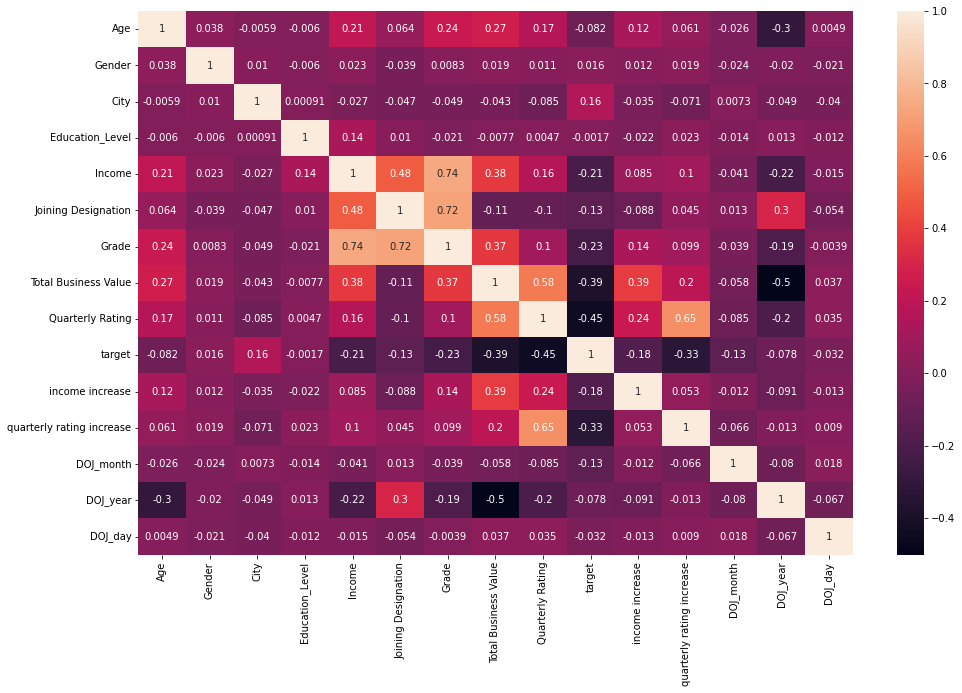

In [309]:
# Plotting a heat map using pearson correlation coeff
plt.figure(figsize=(16,10))
sns.heatmap(train_df.corr(method = 'pearson'), annot=True)
plt.show()

In [310]:
# Based on the heat map present above dropping the highly correlated features. 
train_df.drop(['Joining Designation', 'Grade', 'Quarterly Rating'], axis = 1, inplace = True)
test_df.drop(['Joining Designation', 'Grade', 'Quarterly Rating'], axis = 1, inplace = True)

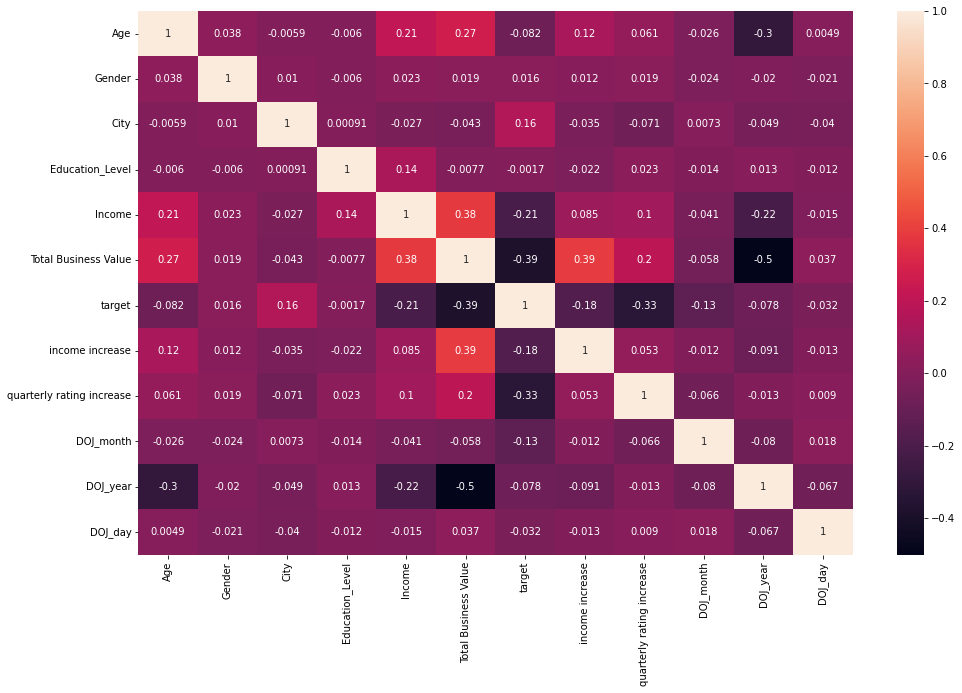

In [311]:
plt.figure(figsize=(16,10))
sns.heatmap(train_df.corr(method = 'pearson'), annot=True)
plt.show()

#### Missing value treatment

In [312]:
# No Null values found in train and test data_set
train_df.isnull().sum()/train_df.shape[0]*100, test_df.isnull().sum()/train_df.shape[0]*100

(Age                          0.0
 Gender                       0.0
 City                         0.0
 Education_Level              0.0
 Income                       0.0
 Total Business Value         0.0
 target                       0.0
 income increase              0.0
 quarterly rating increase    0.0
 DOJ_month                    0.0
 DOJ_year                     0.0
 DOJ_day                      0.0
 dtype: float64,
 Age                          0.0
 Gender                       0.0
 City                         0.0
 Education_Level              0.0
 Income                       0.0
 Total Business Value         0.0
 target                       0.0
 income increase              0.0
 quarterly rating increase    0.0
 DOJ_month                    0.0
 DOJ_year                     0.0
 DOJ_day                      0.0
 dtype: float64)

#### Outlier treatment

In [313]:
# Will be using IQR method to treat the outliers present in the continuos variables
def IQR(col):
    Q3 = np.percentile(col, 75)
    Q1 = np.percentile(col, 25)
    iqr = Q3-Q1
    upper_lmt = Q3+1.5*iqr
    lower_lmt = Q1-1.5*iqr
    return lower_lmt, upper_lmt

In [314]:
for fea in cont_fea:
    train_df = train_df[(train_df[fea]>=IQR(train_df[fea])[0])&(train_df[fea]<=IQR(train_df[fea])[1])]

#### Duplicates treatment

In [315]:
# No duplicates found
train_df.duplicated().value_counts()

False    1611
dtype: int64

#### Training classification models on different algorithms

In [316]:
# Scaling the features
from sklearn.preprocessing import MinMaxScaler
train_df = pd.DataFrame(columns=train_df.columns, data = MinMaxScaler().fit_transform(train_df))
test_df = pd.DataFrame(columns=test_df.columns, data = MinMaxScaler().fit_transform(test_df))

In [317]:
# Defining predictors and target variables for test and train data set
y_train = train_df['target']
x_train = train_df.drop('target', axis = 1)
y_test = test_df['target']
x_test = test_df.drop('target', axis = 1)

##### Class imbalance check

In [318]:
# We can see that there is a huge imbalance of classes. Will be using weighted balancing method while model training
y_train.value_counts() 

1.0    1218
0.0     393
Name: target, dtype: int64

##### Defining type1 and type 2 error before modelling
- 1 - Driver resigned, 0 - Drive still working
- type1 error (False postive) : Model has falsely predicted that a driver will leave the company.
- type2 error (False negative) : Model has falsely predicted that a driver will still be employed.  
- Will be tuning my model based on recall score which controls false negatives as our main objective is focused on reducing driver team attrition. Will try to reduce the type2 error, so that better business decisions can be made to retain existing drivers. 

##### Starting with Logistic regression

In [319]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, precision_score

In [320]:
from sklearn.linear_model import LogisticRegression
LR_params = {'C':1/np.arange(1, 100, 1)}
LR = GridSearchCV(LogisticRegression(class_weight= {1:1, 0:1218/393}), LR_params, cv=10, scoring='recall')
LR.fit(x_train, y_train)
LR_y_pred = LR.predict(x_test)
LR_recall_score = recall_score(y_test, LR_y_pred)

In [321]:
# We got 0.86 as our recall score on test data set which is fairly good
{'test': LR_recall_score, 'train': recall_score(y_train, LR.predict(x_train)), 'parameters': LR.best_params_}

{'test': 0.8623853211009175,
 'train': 0.8513957307060755,
 'parameters': {'C': 0.010101010101010102}}

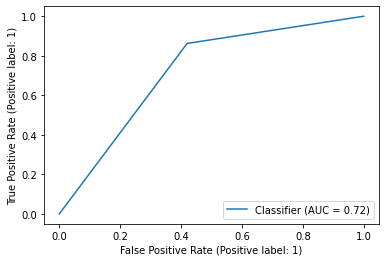

In [322]:
# We got 0.72 as our ROC score on test data set which is not the best, ROC curve fails when there is an imbalance of classes.
RocCurveDisplay.from_predictions(y_test, LR_y_pred)

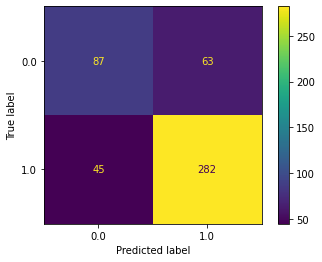

In [323]:
# Our false negatives are lesser than false positives as we focused on recall
ConfusionMatrixDisplay.from_predictions(y_test, LR_y_pred)

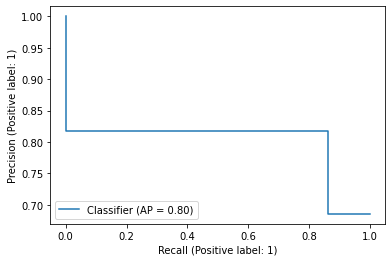

In [324]:
# We got 0.80 as our PRC score on test data set which is good.
PrecisionRecallDisplay.from_predictions(y_test, LR_y_pred)

#### Decision Tree

In [325]:
from sklearn.tree import DecisionTreeClassifier
DT_params = {'max_depth':np.arange(1, 15, 1)}
DT = GridSearchCV(DecisionTreeClassifier(class_weight= {1:1, 0:1218/393}), DT_params, cv=10, scoring='recall')
DT.fit(x_train, y_train)
DT_y_pred = DT.predict(x_test)
DT_recall_score = recall_score(y_test, DT_y_pred)

In [326]:
# We got 0.97 as our recall score on test data set which is very high as compared to LR. DT is a clear winner as of now. 
{'test': DT_recall_score, 'train': recall_score(y_train, DT.predict(x_train)), 'parameters': DT.best_params_}

{'test': 0.9785932721712538,
 'train': 0.9942528735632183,
 'parameters': {'max_depth': 12}}

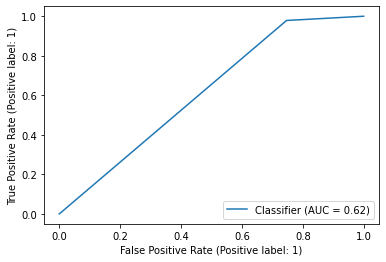

In [327]:
# We got 0.62 as our ROC score on test data set which is not the best, ROC curve fails when there is an imbalance of classes.
RocCurveDisplay.from_predictions(y_test, DT_y_pred)

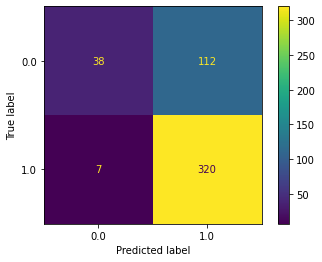

In [328]:
# Our false negatives are way lesser than false positives as we focused on recall score. False negatives are lesser as compared 
# to LR
ConfusionMatrixDisplay.from_predictions(y_test, DT_y_pred)

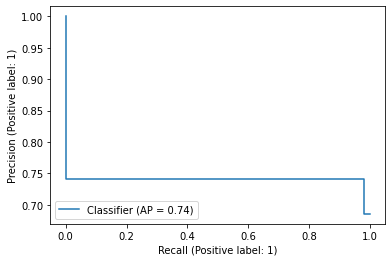

In [329]:
# We got as our PRC score on test data set which is decent.
PrecisionRecallDisplay.from_predictions(y_test, DT_y_pred)

#### Bagging-Random forest

In [330]:
from sklearn.ensemble import RandomForestClassifier
RF_params = {'max_depth':np.arange(1, 15, 1), 'n_estimators':np.arange(25,125,25)}
RF = GridSearchCV(RandomForestClassifier(class_weight= {1:1, 0:1218/393}, n_jobs=-1), RF_params, cv=10, scoring='recall')
RF.fit(x_train, y_train)
RF_y_pred = RF.predict(x_test)
RF_recall_score = recall_score(y_test, RF_y_pred)

In [331]:
# We got 0.98 as our recall score on test data set which is slightly better than DT.
{'test': RF_recall_score, 'train': recall_score(y_train, RF.predict(x_train)), 'parameters': RF.best_params_}

{'test': 0.9877675840978594,
 'train': 1.0,
 'parameters': {'max_depth': 14, 'n_estimators': 75}}

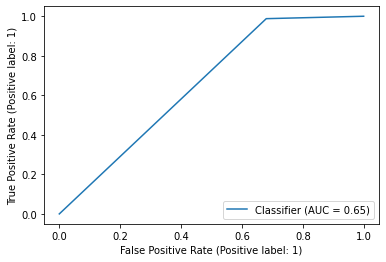

In [332]:
# We got 0.66 as our ROC score on test data set which is better than DT but not the best. 
# ROC curve fails when there is an imbalance of classes.
RocCurveDisplay.from_predictions(y_test, RF_y_pred)

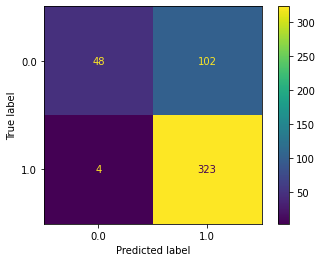

In [333]:
# Our false negatives are way lesser than false positives as we focused on recall score. 
# False positives are lesser as compared to DT.
ConfusionMatrixDisplay.from_predictions(y_test, RF_y_pred)

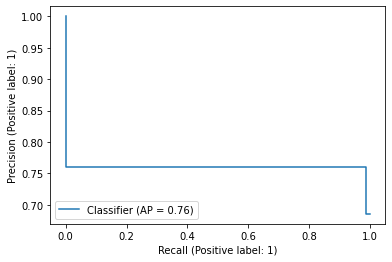

In [334]:
# We got as our PRC score as 0.76 on test data set which is better than DT.
PrecisionRecallDisplay.from_predictions(y_test, RF_y_pred)

#### Boosting-Gradient boosting decision tree

In [335]:
from lightgbm import LGBMClassifier
GB_params = {'max_depth':np.arange(1, 15, 1), 
             'n_estimators':np.arange(25,125,25), 
             'boosting_type':['gbdt', 'goss'],
            'learning_rate':np.arange(0, 1, 0.05)}
GB = GridSearchCV(LGBMClassifier(class_weight= {1:1, 0:1218/393}), GB_params, cv=10, scoring='recall')
GB.fit(x_train, y_train)
GB_y_pred = GB.predict(x_test)
GB_recall_score = recall_score(y_test, GB_y_pred)

In [336]:
# We can see that test scores of GBDT and rf are identical. I will consider this as the best model as of now. 
{'test': GB_recall_score, 'train': recall_score(y_train, GB.predict(x_train)), 'parameters': GB.best_params_}

{'test': 0.9877675840978594,
 'train': 1.0,
 'parameters': {'boosting_type': 'gbdt',
  'learning_rate': 0.75,
  'max_depth': 9,
  'n_estimators': 75}}

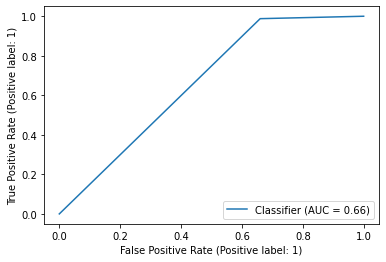

In [337]:
# We got 0.66 as our ROC score on test data set which is better than DT but not the best. 
# ROC curve fails when there is an imbalance of classes.
RocCurveDisplay.from_predictions(y_test, GB_y_pred)

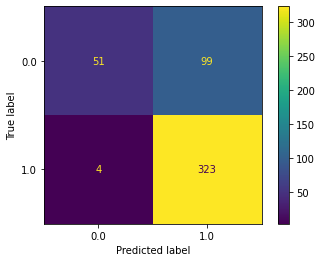

In [338]:
# Our false negatives are way lesser than false positives as we focused on recall score. 
# False positives are lesser as compared to DT and RF.
# only differenc between GB and RF are the false positive values. I will consider this as the best model as of now. 
ConfusionMatrixDisplay.from_predictions(y_test, GB_y_pred)

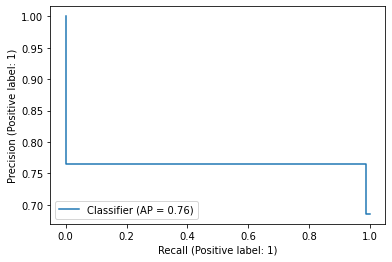

In [339]:
# We got as our PRC score as 0.76 on test data set which is better than DT.
PrecisionRecallDisplay.from_predictions(y_test, GB_y_pred)

#### Checking Feature importance with our GB model

In [340]:
# Initializing our GB model
GB_model = GB.best_estimator_
GB_model

LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
               max_depth=9, n_estimators=75)

In [341]:
fea_imp = pd.DataFrame(data={'features':x_train.columns, 'importance':GB_model.feature_importances_})

In [342]:
fea_imp.sort_values(by='importance', inplace=True)

In [343]:
fea_imp

,features,importance
6,income increase,0
7,quarterly rating increase,36
1,Gender,40
3,Education_Level,59
9,DOJ_year,90
8,DOJ_month,206
2,City,244
10,DOJ_day,251
0,Age,272
5,Total Business Value,364


In [344]:
ordered_fea = np.array(fea_imp['features'])
ordered_fea

array(['income increase', 'quarterly rating increase', 'Gender',
       'Education_Level', 'DOJ_year', 'DOJ_month', 'City', 'DOJ_day',
       'Age', 'Total Business Value', 'Income'], dtype=object)

In [345]:
from sklearn.model_selection import cross_validate
# Will drop the above features one by one and check if I get a same score on a model with less features
val_scores = []
for i in range(1,len(ordered_fea)):
    c_val = cross_validate(LGBMClassifier(n_estimators = 75, max_depth=9, learning_rate=0.75, class_weight= {1:1, 0:1218/393}),
                   x_train.drop(ordered_fea[:i], axis = 1), y_train, scoring='recall', cv=10)
    val_scores.append(c_val['test_score'].mean())

In [346]:
val_scores

[0.9515783769136974,
 0.9335117192792304,
 0.9343313914103779,
 0.9367836336539765,
 0.8514157973174367,
 0.8127828207559953,
 0.7996748408074786,
 0.7758908007045116,
 0.7093618750846769,
 0.5919861807343179]

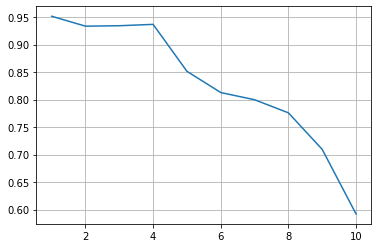

In [347]:
# We can sacrifice a bit of recall score and drop 4 features to reduce the complexity of our model. 
# [income increase', 'quarterly rating increase', 'Gender', 'Education_Level'] are the features to be dropped.
sns.lineplot(x = np.arange(1,len(ordered_fea),1), y = val_scores)
plt.grid()
plt.show()

In [348]:
# modified x train
new_x_train = x_train.drop(ordered_fea[:4], axis = 1)
new_x_test = x_test.drop(ordered_fea[:4], axis = 1)

In [349]:
from sklearn.model_selection import StratifiedKFold
test_scores = []
best_models = []
for train_idx, val_idx in StratifiedKFold(n_splits = 10).split(x_train, y_train):
    GB_model = LGBMClassifier(n_estimators = 75, max_depth=9, learning_rate=0.75, class_weight= {1:1, 0:1218/393})
    GB_model.fit(new_x_train.iloc[train_idx], y_train.iloc[train_idx])
    y_hat = GB_model.predict(new_x_test)
    test_scores.append(recall_score(y_test, y_hat))
    best_models.append(GB_model)

In [350]:
# We can see that even after removing the features we got the test score of 0.99 on our new data set which is very high
np.array(test_scores).mean()

0.989296636085627

In [351]:
# I can conclude that these are the best set of models which can be deployed into production
best_models

[LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimators=75),
 LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimators=75),
 LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimators=75),
 LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimators=75),
 LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimators=75),
 LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimators=75),
 LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimators=75),
 LGBMClassifier(class_weight={0: 3.099236641221374, 1: 1}, learning_rate=0.75,
                max_depth=9, n_estimato